In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [45]:
N, T, m = 3, 7, 2
X = np.random.random((N,T,m)).astype(np.float32)
Y = np.random.random((N, 1)).astype(np.float32)

In [46]:
X[0, -2:] = -100
msk = L.Masking(mask_value=-100)
X

array([[[   0.6088873 ,    0.72217745],
        [   0.90148866,    0.6452914 ],
        [   0.56526315,    0.41411102],
        [   0.54522693,    0.24928297],
        [   0.487642  ,    0.37346917],
        [-100.        , -100.        ],
        [-100.        , -100.        ]],

       [[   0.43218434,    0.69822174],
        [   0.7645032 ,    0.52073455],
        [   0.8319189 ,    0.90506285],
        [   0.6932397 ,    0.10851155],
        [   0.92189085,    0.8566777 ],
        [   0.81903327,    0.85702413],
        [   0.14210367,    0.4927199 ]],

       [[   0.94203234,    0.13393353],
        [   0.52912635,    0.59394884],
        [   0.7125795 ,    0.8429171 ],
        [   0.6102545 ,    0.62961495],
        [   0.163841  ,    0.4671248 ],
        [   0.45647967,    0.41673592],
        [   0.9668638 ,    0.5878279 ]]], dtype=float32)

In [47]:
(msk(X[:, :, :1])).numpy()

array([[[ 0.6088873 ],
        [ 0.90148866],
        [ 0.56526315],
        [ 0.54522693],
        [ 0.487642  ],
        [-0.        ],
        [-0.        ]],

       [[ 0.43218434],
        [ 0.7645032 ],
        [ 0.8319189 ],
        [ 0.6932397 ],
        [ 0.92189085],
        [ 0.81903327],
        [ 0.14210367]],

       [[ 0.94203234],
        [ 0.52912635],
        [ 0.7125795 ],
        [ 0.6102545 ],
        [ 0.163841  ],
        [ 0.45647967],
        [ 0.9668638 ]]], dtype=float32)

In [48]:
tf.nn.softmax(msk(X[:, :, :1]), axis=-2)[0]

<tf.Tensor: id=6909, shape=(7, 1), dtype=float32, numpy=
array([[0.16104943],
       [0.2157915 ],
       [0.15417482],
       [0.15111648],
       [0.14266025],
       [0.08760376],
       [0.08760376]], dtype=float32)>

In [51]:
tf.nn.sigmoid(X[:, 1:, :1])

<tf.Tensor: id=6949, shape=(3, 6, 1), dtype=float32, numpy=
array([[[0.7112553 ],
        [0.63766944],
        [0.6330275 ],
        [0.61955076],
        [0.        ],
        [0.        ]],

       [[0.6823306 ],
        [0.69676054],
        [0.6666872 ],
        [0.71542716],
        [0.69403106],
        [0.53546625]],

       [[0.6292793 ],
        [0.67097086],
        [0.64799887],
        [0.5408689 ],
        [0.61217874],
        [0.7244939 ]]], dtype=float32)>

In [34]:
inp = keras.Input(shape=X.shape)

msk = L.Masking(mask_value=np.float32(-10))
fc = L.Dense(units=5)
fco = L.Dense(units=5)
rnn = L.GRU(units=3, return_sequences=True)
fc2 = L.Dense(units=1)

print(inp.shape)
inp  = tf.split(inp, inp.shape[0] // 2, axis=0)
y_fv = msk(inp)
mskv = tf.reduce_all(tf.not_equal(inp, -10), axis=-1)
mskv = tf.cast(mskv, dtype=tf.int32)
offs = tf.reduce_sum(mskv, axis=-1)

y_inv = msk(tf.reverse_sequence(inp, seq_lengths=offs, seq_axis=1, batch_axis=0))

v = fc(y_fv)
v_inv = fc(y_inv)
h = rnn(v_inv)
b = fco(h)
by = b * v
y = tf.reduce_sum(by, axis=-2)
y = fc2(y)
model = keras.Model(inputs=inp, outputs=y)

(None, 4, 7, 2)


TypeError: unsupported operand type(s) for //: 'NoneType' and 'int'

In [12]:
X[:, -4:] = -10

X[1, -6:] = -10
model(X[:, :]), model(X[:, :-1])

(<tf.Tensor: id=6160, shape=(3, 1), dtype=float32, numpy=
 array([[0.24680601],
        [0.07324187],
        [0.13545142]], dtype=float32)>,
 <tf.Tensor: id=6621, shape=(3, 1), dtype=float32, numpy=
 array([[0.24680601],
        [0.07324187],
        [0.13545142]], dtype=float32)>)

In [5]:
model(X) - model(X[:, :-5])

InvalidArgumentError: Incompatible shapes: [10,7,5] vs. [10,2,5] [Op:Sub] name: sub/

In [38]:
tf.reverse_sequence(X[:1], seq_lengths=X[:1].shape[-3] * [X.shape[-2]], seq_axis=-2)

<tf.Tensor: id=223, shape=(1, 7, 2), dtype=float32, numpy=
array([[[  0.8217553 ,   0.9094859 ],
        [  0.3038528 ,   0.4574116 ],
        [  0.31723672,   0.14838189],
        [-10.        , -10.        ],
        [-10.        , -10.        ],
        [-10.        , -10.        ],
        [-10.        , -10.        ]]], dtype=float32)>

In [47]:
X[:1]

array([[[  0.8217553 ,   0.9094859 ],
        [  0.3038528 ,   0.4574116 ],
        [  0.31723672,   0.14838189],
        [-10.        , -10.        ],
        [-10.        , -10.        ],
        [-10.        , -10.        ],
        [-10.        , -10.        ]]], dtype=float32)

In [48]:
msk = tf.reduce_all(tf.not_equal(X[:2], -10), axis=-1)
msk = tf.cast(msk, dtype=tf.int32)
offs = tf.reduce_sum(msk, axis=-1)
offs

<tf.Tensor: id=287, shape=(2,), dtype=int32, numpy=array([3, 1], dtype=int32)>

In [49]:
msk = L.Masking(mask_value=-10)
msk(tf.reverse_sequence(X[:2], seq_lengths=offs, seq_axis=1, batch_axis=0))

<tf.Tensor: id=296, shape=(2, 7, 2), dtype=float32, numpy=
array([[[ 0.31723672,  0.14838189],
        [ 0.3038528 ,  0.4574116 ],
        [ 0.8217553 ,  0.9094859 ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[ 0.84418404,  0.618427  ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]]], dtype=float32)>

In [28]:
msk(X[:2])

<tf.Tensor: id=6762, shape=(2, 7, 2), dtype=float32, numpy=
array([[[-0.        , -0.        ],
        [-0.        , -0.        ],
        [ 0.42450413,  0.5582725 ],
        [ 0.03606643,  0.16379678],
        [ 0.98588264,  0.10061571],
        [ 0.26833102,  0.5919821 ],
        [ 0.04283847,  0.07803915]],

       [[ 0.8090406 ,  0.21181963],
        [ 0.7092773 ,  0.05737368],
        [ 0.4905173 ,  0.59327453],
        [ 0.14978719,  0.22194387],
        [ 0.3862516 ,  0.7885808 ],
        [ 0.3587108 ,  0.49720868],
        [ 0.71081185,  0.33828244]]], dtype=float32)>

In [29]:
X

array([[[-1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02],
        [ 4.2450413e-01,  5.5827248e-01],
        [ 3.6066432e-02,  1.6379678e-01],
        [ 9.8588264e-01,  1.0061571e-01],
        [ 2.6833102e-01,  5.9198213e-01],
        [ 4.2838469e-02,  7.8039154e-02]],

       [[ 8.0904061e-01,  2.1181963e-01],
        [ 7.0927727e-01,  5.7373684e-02],
        [ 4.9051729e-01,  5.9327453e-01],
        [ 1.4978719e-01,  2.2194387e-01],
        [ 3.8625160e-01,  7.8858078e-01],
        [ 3.5871080e-01,  4.9720868e-01],
        [ 7.1081185e-01,  3.3828244e-01]],

       [[ 9.8855788e-01,  5.9219545e-01],
        [ 8.5178751e-01,  8.9589912e-01],
        [ 5.8684576e-01,  1.6893840e-01],
        [ 9.2333066e-01,  6.0553485e-01],
        [ 6.8947476e-01,  5.4251802e-01],
        [ 9.5534128e-01,  9.4032651e-01],
        [ 2.9521921e-01,  6.6151160e-01]],

       [[ 4.8100618e-01,  2.2123668e-03],
        [ 8.8870037e-01,  5.0715256e-01],
        [ 4.4176090e-01,  7.

In [31]:
tf.split(X, X.shape[0] // 2, axis=0)

[<tf.Tensor: id=6769, shape=(2, 7, 2), dtype=float32, numpy=
 array([[[-1.0000000e+02, -1.0000000e+02],
         [-1.0000000e+02, -1.0000000e+02],
         [ 4.2450413e-01,  5.5827248e-01],
         [ 3.6066432e-02,  1.6379678e-01],
         [ 9.8588264e-01,  1.0061571e-01],
         [ 2.6833102e-01,  5.9198213e-01],
         [ 4.2838469e-02,  7.8039154e-02]],
 
        [[ 8.0904061e-01,  2.1181963e-01],
         [ 7.0927727e-01,  5.7373684e-02],
         [ 4.9051729e-01,  5.9327453e-01],
         [ 1.4978719e-01,  2.2194387e-01],
         [ 3.8625160e-01,  7.8858078e-01],
         [ 3.5871080e-01,  4.9720868e-01],
         [ 7.1081185e-01,  3.3828244e-01]]], dtype=float32)>,
 <tf.Tensor: id=6770, shape=(2, 7, 2), dtype=float32, numpy=
 array([[[0.9885579 , 0.59219545],
         [0.8517875 , 0.8958991 ],
         [0.58684576, 0.1689384 ],
         [0.92333066, 0.60553485],
         [0.68947476, 0.542518  ],
         [0.9553413 , 0.9403265 ],
         [0.2952192 , 0.6615116 ]],
 
      

In [23]:
tf.split?

In [28]:
model(X) - model(X[:, 4:])

<tf.Tensor: id=14667, shape=(10, 1), dtype=float32, numpy=
array([[-0.56867504],
       [-0.48774862],
       [-0.5320935 ],
       [-0.5174241 ],
       [-0.5051575 ],
       [-0.5465579 ],
       [-0.47080112],
       [-0.50887513],
       [-0.40951133],
       [-0.4762256 ]], dtype=float32)>

In [25]:
model(X[:, 1:])

<tf.Tensor: id=5926, shape=(10, 1), dtype=float32, numpy=
array([[0.03433532],
       [0.01121121],
       [0.01130204],
       [0.00426761],
       [0.03203617],
       [0.04435151],
       [0.02329135],
       [0.01734853],
       [0.03443678],
       [0.01932057]], dtype=float32)>

In [70]:
X[0, 3:]

array([[-10.        , -10.        , -10.        ],
       [  0.8217417 ,   0.5983284 ,   0.9266853 ],
       [  0.8564886 ,   0.58452183,   0.03146208],
       [  0.12346883,   0.34937596,   0.7357722 ],
       [  0.7637851 ,   0.16241547,   0.82624596],
       [  0.0454489 ,   0.03894287,   0.64615625],
       [  0.36622438,   0.65507436,   0.7746543 ],
       [  0.7537867 ,   0.8268556 ,   0.7188605 ],
       [  0.47962505,   0.99221873,   0.887502  ],
       [  0.71823686,   0.86094797,   0.75644326],
       [  0.6051172 ,   0.7428403 ,   0.7038012 ],
       [  0.5004389 ,   0.93370366,   0.2033808 ]], dtype=float32)

In [86]:
df = h5py.File("data/backblaze_prepared.h5", "r")

In [87]:
df.keys()

<KeysViewHDF5 ['X', 'Y']>

In [88]:
df["X"].shape

(35666, 1277, 42)

In [89]:
df["Y"].shape

(35666,)

In [90]:
np.histogram(df["Y"])

(array([32941,     0,     0,     0,     0,     0,     0,     0,     0,
         2725]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [91]:
X = df["X"][:1000]

In [98]:
X.shape

X[X == -100] = 0

In [100]:
X.min(axis=1).min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [144]:
ts = np.array([np.sin(np.linspace(0, 2 * np.pi, 25) + off) for off in np.linspace(0, np.pi, 10)])
ts.shape

(10, 25)

In [117]:
ts = tf.convert_to_tensor(ts, dtype=np.float32)

In [118]:
tf.summary.write("coeff", ts)

<tf.Tensor: id=40871, shape=(), dtype=bool, numpy=False>

In [119]:
tf.summary.write("contrib", ts)

<tf.Tensor: id=40873, shape=(), dtype=bool, numpy=False>

In [120]:
tf.summary.flush(writer)

In [131]:
_x, _y = np.meshgrid(np.arange(0, ts.shape[1]), np.arange(0, ts.shape[0]))

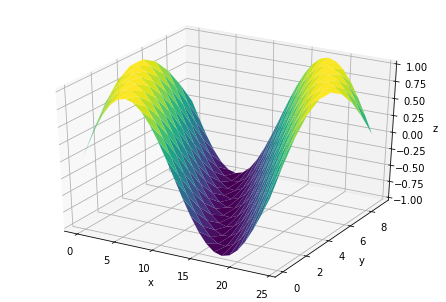

In [136]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure()

ax = Axes3D(fig) #<-- Note the difference from your original code...

ax.plot_surface(_x, _y, ts, cmap='viridis');
ax.clabel(cset, fontsize=9, inline=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [145]:
with writer.as_default():
    tf.summary.write("qwsda", tensor=ts, step=0)

In [146]:
tf.summary.flush(writer)